In [20]:
import os
import cv2
import numpy as np
import random
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image
import torch
from torchvision import transforms

In [21]:
DATA_DIR = "data/stanford_dogs/Images"
OUTPUT_DIR = "data/Processed"
IMG_SIZE = (224, 224)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [22]:
def load_dataset(data_dir):
    all_paths = glob(os.path.join(data_dir, "*", "*.jpg"))
    all_labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]
    return all_paths, all_labels

In [23]:
def resize_image(image, target_size=IMG_SIZE):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def normalize_image(image):
    return image.astype(np.float32) / 255.0

def preprocess_image(path, target_size=IMG_SIZE, to_rgb=True, normalize=True):
    img = cv2.imread(path)
    if img is None:
        return None
    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize_image(img, target_size)
    if normalize:
        img = normalize_image(img)
    return img

In [24]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

In [25]:
final_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p=0.3),
    transforms.RandomApply([transforms.RandomErasing(p=1.0, scale=(0.1, 0.2))], p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5),
    transforms.Normalize(mean, std)
])

In [26]:
def split_and_save_dataset(image_paths, labels):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    SPLIT_RATIOS = {"train": 0.7, "validation": 0.15, "test": 0.15}

    class_to_paths = {}
    for path, label in zip(image_paths, labels):
        class_to_paths.setdefault(label, []).append(path)

    path_to_split = {}
    for label, paths in class_to_paths.items():
        random.shuffle(paths)
        total = len(paths)
        train_end = int(SPLIT_RATIOS["train"] * total)
        val_end = train_end + int(SPLIT_RATIOS["validation"] * total)
        for i, path in enumerate(paths):
            if i < train_end:
                path_to_split[path] = "train"
            elif i < val_end:
                path_to_split[path] = "validation"
            else:
                path_to_split[path] = "test"

    for split in SPLIT_RATIOS.keys():
        for label in class_to_paths:
            os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Preprocessing"):
        img = preprocess_image(path)
        if img is None:
            print(f"[READ FAIL] {path}")
            continue
        save_img = (img * 255).astype(np.uint8)
        save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)
        split = path_to_split.get(path, "train")
        save_dir = os.path.join(OUTPUT_DIR, split, label)
        cv2.imwrite(os.path.join(save_dir, os.path.basename(path)), save_img)

In [27]:
def visualize_sample(image_path):
    img_cv2 = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    img_tensor = final_transform(img_pil)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = (img_np * std + mean).clip(0, 1)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.axis('off')
    plt.title("Augmented Image")
    plt.show()

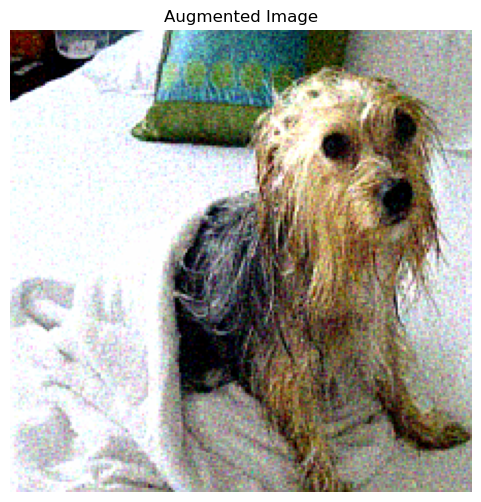

In [43]:
if __name__ == "__main__":
    image_paths, labels = load_dataset(DATA_DIR)
    visualize_sample(image_paths[0])